# Tutorial 1: Surrogate Gradients for Spiking Neural Networks - Basics

This tutorial introduces **surrogate gradients**, a fundamental technique for training spiking neural networks (SNNs). We'll cover:

1. **What are Surrogate Gradients?** - The problem and solution
2. **How Surrogate Gradients Work** - The straight-through estimator
3. **Common Surrogate Functions** - Overview of popular methods
4. **Visualization & Comparison** - Understanding different surrogates
5. **Practical Usage** - Using surrogates in SNNs

## Setup

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import braintools.surrogate as surrogate

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


## 1. What are Surrogate Gradients?

### The Problem: Non-Differentiable Spikes

Spiking neurons produce discrete binary outputs (0 or 1) through a **Heaviside step function**:

$$
s = H(V - V_{\text{th}}) = \begin{cases}
1 & \text{if } V \geq V_{\text{th}} \\
0 & \text{otherwise}
\end{cases}
$$

The problem: **The derivative is zero almost everywhere!**

$$
\frac{\partial H(x)}{\partial x} = \begin{cases}
0 & \text{if } x \neq 0 \\
\text{undefined} & \text{if } x = 0
\end{cases}
$$

This means we **cannot use gradient descent** to train SNNs!

### The Solution: Surrogate Gradients

**Surrogate gradients** replace the true (zero) gradient with a smooth approximation during backpropagation:

- **Forward pass**: Use the real Heaviside step function $H(x)$
- **Backward pass**: Use a smooth surrogate function $\sigma(x)$ for gradients

This is called the **straight-through estimator**.

=== THE GRADIENT PROBLEM ===


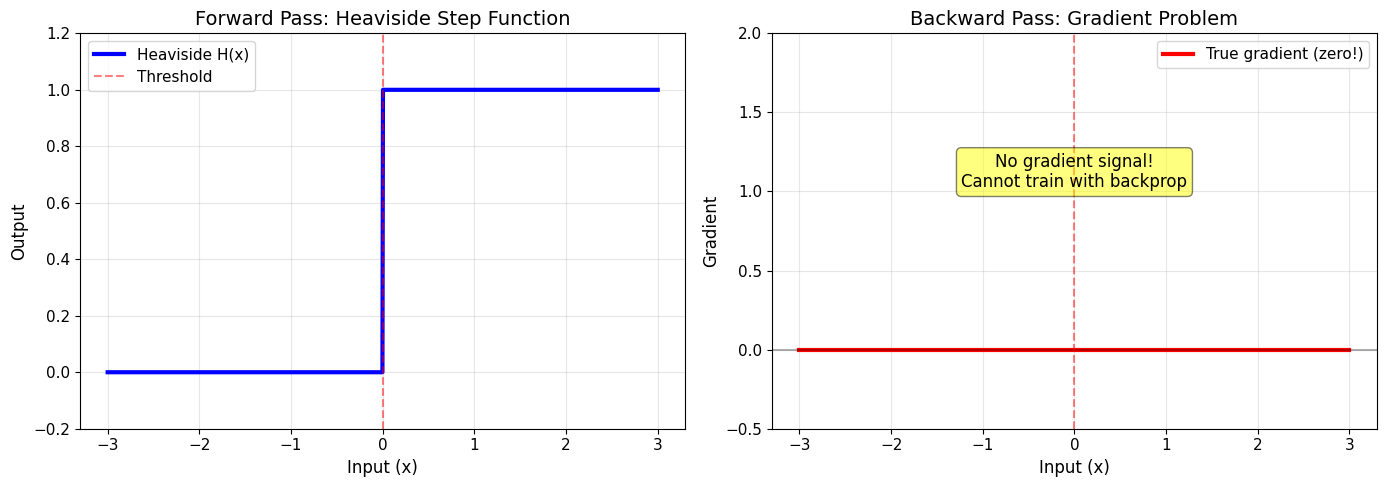


❌ Problem: The Heaviside function has zero gradient everywhere
❌ This prevents gradient-based learning in SNNs

✅ Solution: Use surrogate gradients during backpropagation!


In [2]:
# Demonstrate the problem
print("=== THE GRADIENT PROBLEM ===")

x = jnp.linspace(-3, 3, 1000)

# True Heaviside function
heaviside = jnp.where(x >= 0, 1.0, 0.0)

# Visualize the problem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Heaviside function
ax1.plot(x, heaviside, 'b-', linewidth=3, label='Heaviside H(x)')
ax1.axvline(0, color='red', linestyle='--', alpha=0.5, label='Threshold')
ax1.set_xlabel('Input (x)', fontsize=12)
ax1.set_ylabel('Output', fontsize=12)
ax1.set_title('Forward Pass: Heaviside Step Function', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.2, 1.2)

# Plot gradient (which is zero everywhere)
true_gradient = jnp.zeros_like(x)
ax2.plot(x, true_gradient, 'r-', linewidth=3, label='True gradient (zero!)')
ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Input (x)', fontsize=12)
ax2.set_ylabel('Gradient', fontsize=12)
ax2.set_title('Backward Pass: Gradient Problem', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.5, 2)

# Add text annotations
ax2.text(0, 1, 'No gradient signal!\nCannot train with backprop', 
         ha='center', va='bottom', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n❌ Problem: The Heaviside function has zero gradient everywhere")
print("❌ This prevents gradient-based learning in SNNs")
print("\n✅ Solution: Use surrogate gradients during backpropagation!")

## 2. How Surrogate Gradients Work

The **straight-through estimator** works as follows:

1. **Forward pass**: Compute spikes using the real Heaviside function
   $$s = H(V - V_{\text{th}})$$

2. **Backward pass**: Compute gradients using a smooth surrogate $\sigma'(x)$
   $$\frac{\partial s}{\partial V} \approx \sigma'(V - V_{\text{th}})$$

This allows gradient flow through the network while maintaining discrete spike outputs!

=== SURROGATE GRADIENT SOLUTION ===


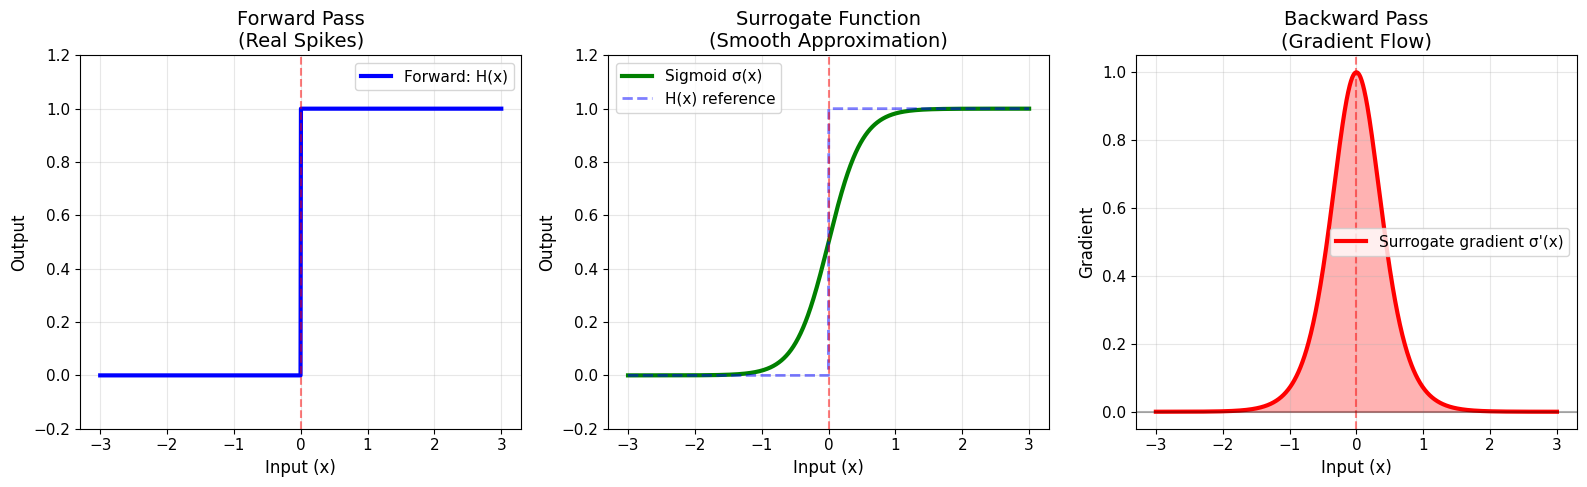


✅ Forward: Binary spikes (0 or 1)
✅ Backward: Smooth gradients for learning
✅ This enables gradient descent training of SNNs!


In [3]:
# Demonstrate surrogate gradient concept
print("=== SURROGATE GRADIENT SOLUTION ===")

# Example: Sigmoid surrogate
sg = surrogate.Sigmoid(alpha=4.0)

x = jnp.linspace(-3, 3, 1000)

# Forward pass (always Heaviside)
forward_output = sg(x)

# Surrogate function (for visualization)
surrogate_function = sg.surrogate_fun(x)

# Surrogate gradient (used in backprop)
surrogate_grad = sg.surrogate_grad(x)

# Visualize the solution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Forward pass
axes[0].plot(x, forward_output, 'b-', linewidth=3, label='Forward: H(x)')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Input (x)', fontsize=12)
axes[0].set_ylabel('Output', fontsize=12)
axes[0].set_title('Forward Pass\n(Real Spikes)', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.2, 1.2)

# Surrogate function
axes[1].plot(x, surrogate_function, 'g-', linewidth=3, label='Sigmoid σ(x)')
axes[1].plot(x, forward_output, 'b--', linewidth=2, alpha=0.5, label='H(x) reference')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Input (x)', fontsize=12)
axes[1].set_ylabel('Output', fontsize=12)
axes[1].set_title('Surrogate Function\n(Smooth Approximation)', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.2, 1.2)

# Backward pass
axes[2].plot(x, surrogate_grad, 'r-', linewidth=3, label="Surrogate gradient σ'(x)")
axes[2].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[2].fill_between(x, 0, surrogate_grad, alpha=0.3, color='red')
axes[2].set_xlabel('Input (x)', fontsize=12)
axes[2].set_ylabel('Gradient', fontsize=12)
axes[2].set_title('Backward Pass\n(Gradient Flow)', fontsize=14)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Forward: Binary spikes (0 or 1)")
print("✅ Backward: Smooth gradients for learning")
print("✅ This enables gradient descent training of SNNs!")

=== GRADIENT COMPUTATION DEMONSTRATION ===
Input: 0.0
Forward output (spike): 1.0
Backward gradient: 1.0000

✅ Gradient is non-zero! We can now train with backpropagation.


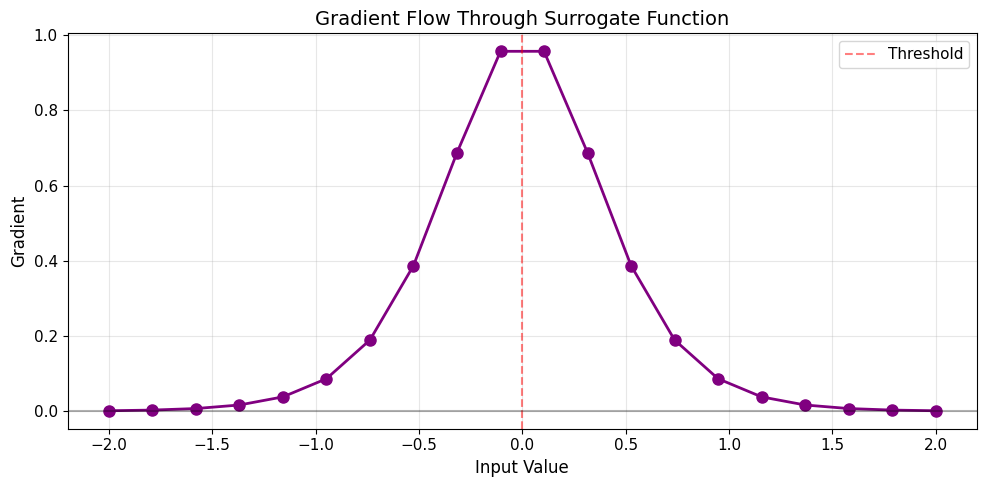


Notice: Gradient is strongest near threshold (x=0)!


In [4]:
# Verify gradient computation works
print("=== GRADIENT COMPUTATION DEMONSTRATION ===")

# Create a simple function using surrogate gradient
sg = surrogate.Sigmoid(alpha=4.0)

def spike_function(x):
    return jnp.sum(sg(x))

# Test gradient computation
test_x = jnp.array([0.0])
gradient = jax.grad(spike_function)(test_x)

print(f"Input: {test_x[0]}")
print(f"Forward output (spike): {sg(test_x)[0]}")
print(f"Backward gradient: {gradient[0]:.4f}")
print(f"\n✅ Gradient is non-zero! We can now train with backpropagation.")

# Show how gradient changes with input
x_vals = jnp.linspace(-2, 2, 20)
grads = jax.vmap(lambda x: jax.grad(spike_function)(jnp.array([x]))[0])(x_vals)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, grads, 'o-', linewidth=2, markersize=8, color='purple')
plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='Threshold')
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Input Value', fontsize=12)
plt.ylabel('Gradient', fontsize=12)
plt.title('Gradient Flow Through Surrogate Function', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNotice: Gradient is strongest near threshold (x=0)!")

## 3. Common Surrogate Gradient Functions

`braintools.surrogate` provides many surrogate gradient functions. Here are the most popular ones:

### Sigmoid-Based Surrogates

1. **Sigmoid**: $\sigma(x) = \frac{1}{1 + e^{-\alpha x}}$, gradient: $\sigma'(x) = \alpha \sigma(x)(1-\sigma(x))$
2. **SoftSign**: $\sigma(x) = \frac{x}{1 + |x|}$
3. **Arctan**: $\sigma(x) = \frac{1}{\pi}\arctan(\alpha x) + \frac{1}{2}$
4. **ERF**: $\sigma(x) = \frac{1}{2}(1 + \text{erf}(\alpha x))$

### Piecewise Surrogates

5. **PiecewiseQuadratic**: Quadratic function with finite support
6. **PiecewiseExp**: Exponential pieces
7. **PiecewiseLeakyRelu**: Leaky ReLU variant

### ReLU-Based Surrogates

8. **ReluGrad**: ReLU-inspired with finite support
9. **LeakyRelu**: Asymmetric gradients

### Distribution-Inspired Surrogates

10. **GaussianGrad**: Gaussian-shaped gradient
11. **MultiGaussianGrad**: Multiple Gaussian components
12. **SlayerGrad**: From the SLAYER algorithm

Let's visualize and compare them!

=== COMMON SURROGATE GRADIENTS ===


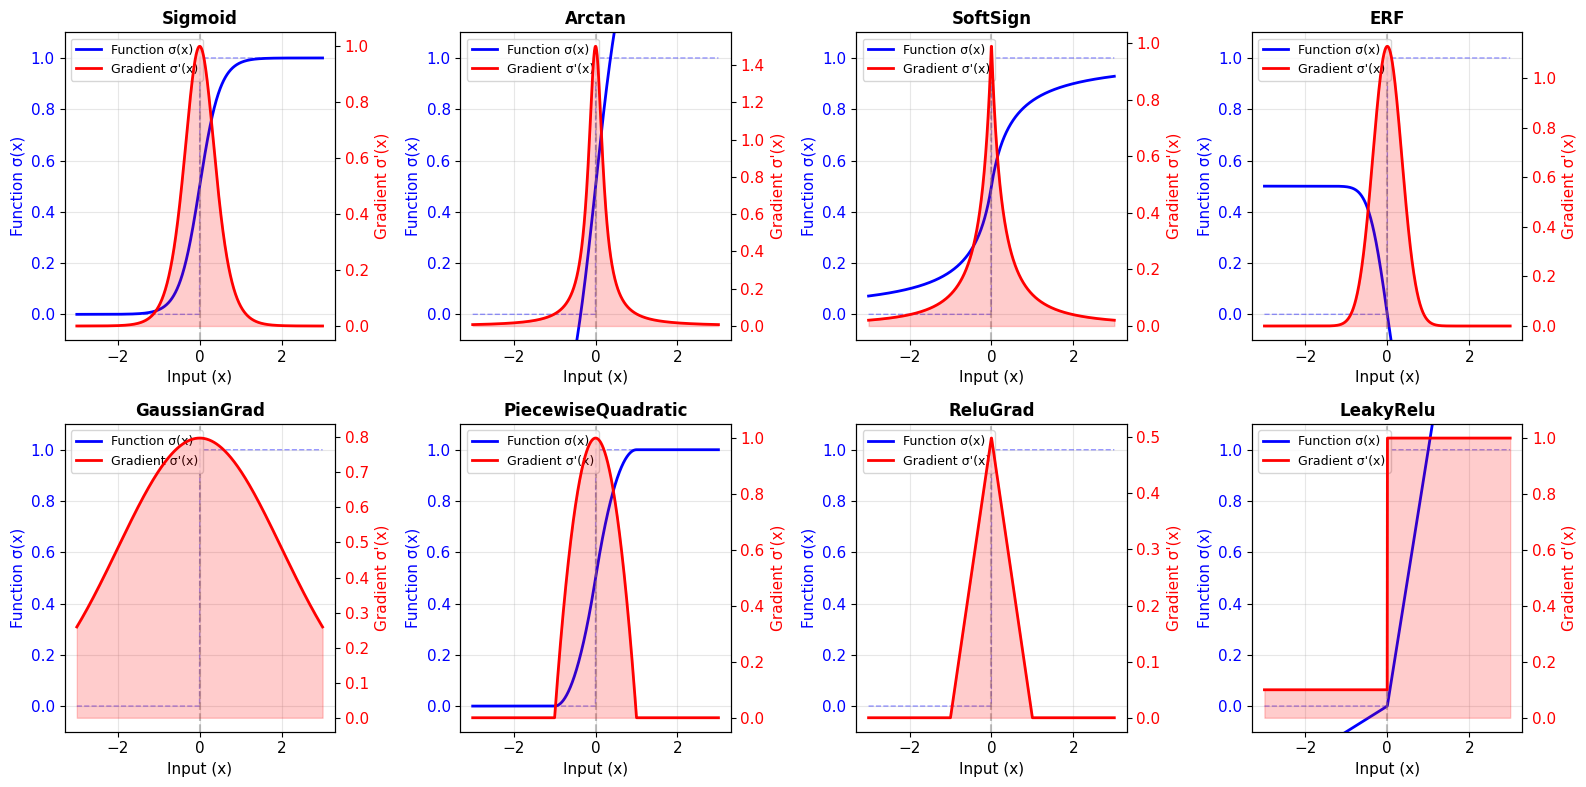


Each surrogate has different characteristics:
• Sigmoid: Smooth, unbounded support
• Arctan: Smooth, unbounded, moderate steepness
• GaussianGrad: Symmetric, bell-shaped gradient
• PiecewiseQuadratic: Finite support (zero gradient outside range)
• ReluGrad: ReLU-like, finite support


In [7]:
# Compare common surrogate functions
print("=== COMMON SURROGATE GRADIENTS ===")

# Define surrogates to compare
surrogates = {
    'Sigmoid': surrogate.Sigmoid(alpha=4.0),
    'Arctan': surrogate.Arctan(alpha=3.0),
    'SoftSign': surrogate.SoftSign(alpha=2.0),
    'ERF': surrogate.ERF(alpha=2.0),
    'GaussianGrad': surrogate.GaussianGrad(sigma=0.5, alpha=1.0),
    'PiecewiseQuadratic': surrogate.PiecewiseQuadratic(alpha=1.0),
    'ReluGrad': surrogate.ReluGrad(alpha=0.5, width=1.0),
    'LeakyRelu': surrogate.LeakyRelu(alpha=0.1, beta=1.0),
}

x = jnp.linspace(-3, 3, 1000)

# Create subplot grid
n_surrogates = len(surrogates)
n_cols = 4
n_rows = (n_surrogates + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for idx, (name, sg) in enumerate(surrogates.items()):
    # Plot surrogate function
    ax = axes[idx]
    ax2 = ax.twinx()

    # Function in blue
    try:
        surrogate_fun = sg.surrogate_fun(x)
        line1 = ax.plot(x, surrogate_fun, 'b-', linewidth=2, label='Function σ(x)')
    except NotImplementedError:
        pass
    ax.plot(x, jnp.where(x >= 0, 1.0, 0.0), 'b--', linewidth=1, alpha=0.4, label='H(x)')

    # Gradient in red
    surrogate_grad = sg.surrogate_grad(x)
    line2 = ax2.plot(x, surrogate_grad, 'r-', linewidth=2, label="Gradient σ'(x)")
    ax2.fill_between(x, 0, surrogate_grad, alpha=0.2, color='red')
    
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Input (x)')
    ax.set_ylabel('Function σ(x)', color='b')
    ax2.set_ylabel("Gradient σ'(x)", color='r')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', fontsize=9)

# Hide extra subplots
for idx in range(len(surrogates), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nEach surrogate has different characteristics:")
print("• Sigmoid: Smooth, unbounded support")
print("• Arctan: Smooth, unbounded, moderate steepness")
print("• GaussianGrad: Symmetric, bell-shaped gradient")
print("• PiecewiseQuadratic: Finite support (zero gradient outside range)")
print("• ReluGrad: ReLU-like, finite support")

## 4. Comparing Gradient Shapes

Different surrogates produce different gradient shapes. Let's focus on the gradients:

=== GRADIENT SHAPE COMPARISON ===


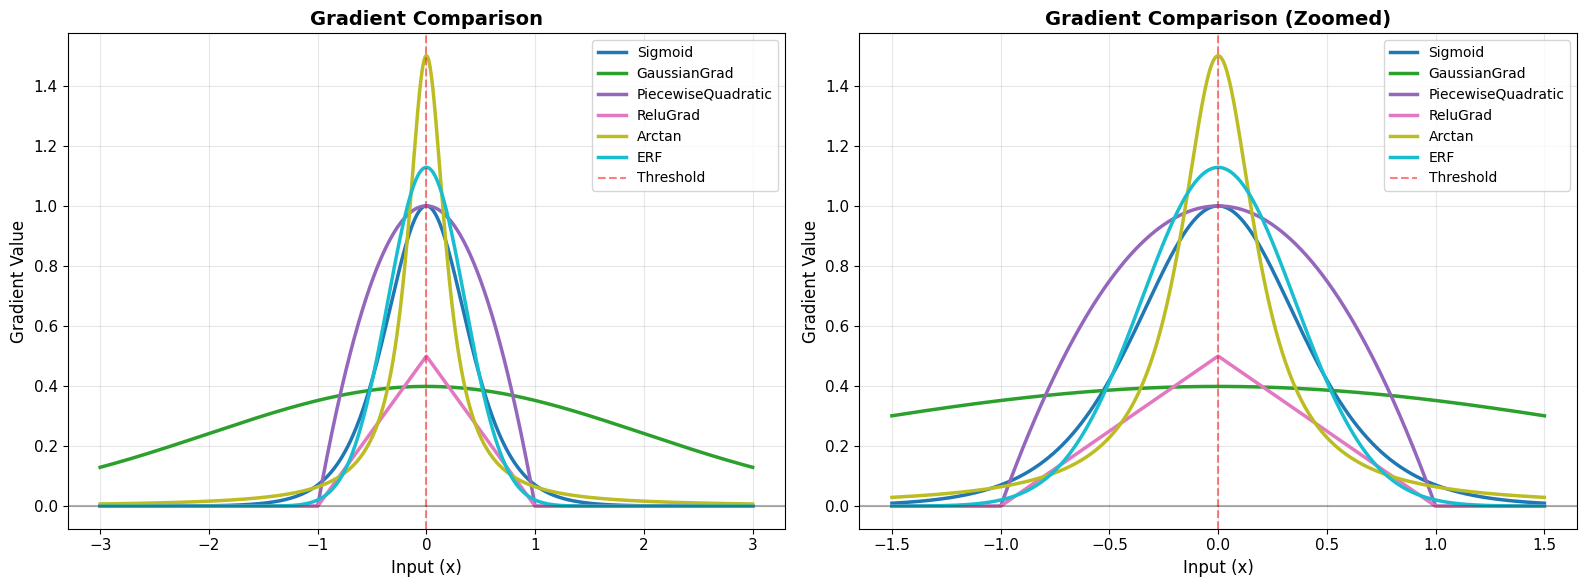


Key observations:
• GaussianGrad: Narrow, peaked gradient
• Sigmoid/Arctan/ERF: Medium width, smooth decay
• PiecewiseQuadratic/ReluGrad: Finite support (hard cutoff)

Choice impacts:
• Narrow gradients: More selective, faster convergence
• Wide gradients: More gradient flow, more stable


In [8]:
# Compare gradient shapes directly
print("=== GRADIENT SHAPE COMPARISON ===")

# Select representative surrogates
compare_surrogates = [
    ('Sigmoid', surrogate.Sigmoid(alpha=4.0)),
    ('GaussianGrad', surrogate.GaussianGrad(sigma=0.5)),
    ('PiecewiseQuadratic', surrogate.PiecewiseQuadratic(alpha=1.0)),
    ('ReluGrad', surrogate.ReluGrad(alpha=0.5, width=1.0)),
    ('Arctan', surrogate.Arctan(alpha=3.0)),
    ('ERF', surrogate.ERF(alpha=2.0)),
]

x = jnp.linspace(-3, 3, 1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot all gradients together
colors = plt.cm.tab10(np.linspace(0, 1, len(compare_surrogates)))

for idx, (name, sg) in enumerate(compare_surrogates):
    grad = sg.surrogate_grad(x)
    ax1.plot(x, grad, linewidth=2.5, label=name, color=colors[idx])

ax1.axvline(0, color='red', linestyle='--', alpha=0.5, label='Threshold')
ax1.axhline(0, color='black', linestyle='-', alpha=0.3)
ax1.set_xlabel('Input (x)', fontsize=12)
ax1.set_ylabel('Gradient Value', fontsize=12)
ax1.set_title('Gradient Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot gradient width comparison (zoomed)
x_zoom = jnp.linspace(-1.5, 1.5, 1000)

for idx, (name, sg) in enumerate(compare_surrogates):
    grad = sg.surrogate_grad(x_zoom)
    ax2.plot(x_zoom, grad, linewidth=2.5, label=name, color=colors[idx])

ax2.axvline(0, color='red', linestyle='--', alpha=0.5, label='Threshold')
ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Input (x)', fontsize=12)
ax2.set_ylabel('Gradient Value', fontsize=12)
ax2.set_title('Gradient Comparison (Zoomed)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("• GaussianGrad: Narrow, peaked gradient")
print("• Sigmoid/Arctan/ERF: Medium width, smooth decay")
print("• PiecewiseQuadratic/ReluGrad: Finite support (hard cutoff)")
print("\nChoice impacts:")
print("• Narrow gradients: More selective, faster convergence")
print("• Wide gradients: More gradient flow, more stable")

## 5. Effect of Hyperparameters

Most surrogate functions have a **steepness parameter** (usually called `alpha`) that controls the shape of the gradient.

=== HYPERPARAMETER EFFECTS: Alpha ===


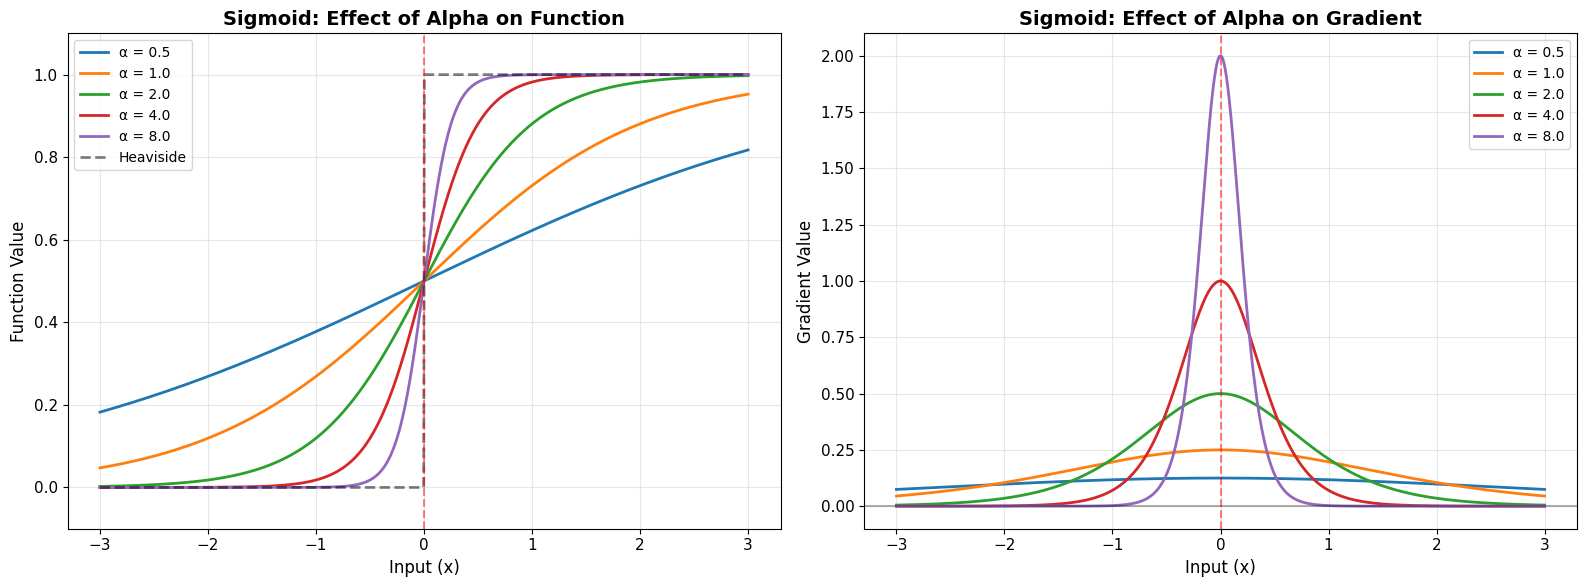


Effect of increasing α:
• Surrogate function becomes steeper (closer to Heaviside)
• Gradient becomes narrower and taller
• Peak gradient value increases

Trade-off:
• High α: More accurate approximation, but narrower gradient flow
• Low α: Wider gradient flow, but less accurate approximation


In [9]:
# Demonstrate effect of alpha parameter
print("=== HYPERPARAMETER EFFECTS: Alpha ===")

alphas = [0.5, 1.0, 2.0, 4.0, 8.0]
x = jnp.linspace(-3, 3, 1000)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sigmoid example
for alpha in alphas:
    sg = surrogate.Sigmoid(alpha=alpha)
    surrogate_fun = sg.surrogate_fun(x)
    axes[0].plot(x, surrogate_fun, linewidth=2, label=f'α = {alpha}')

axes[0].plot(x, jnp.where(x >= 0, 1.0, 0.0), 'k--', linewidth=2, alpha=0.5, label='Heaviside')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Input (x)', fontsize=12)
axes[0].set_ylabel('Function Value', fontsize=12)
axes[0].set_title('Sigmoid: Effect of Alpha on Function', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

# Gradients
for alpha in alphas:
    sg = surrogate.Sigmoid(alpha=alpha)
    grad = sg.surrogate_grad(x)
    axes[1].plot(x, grad, linewidth=2, label=f'α = {alpha}')

axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Input (x)', fontsize=12)
axes[1].set_ylabel('Gradient Value', fontsize=12)
axes[1].set_title('Sigmoid: Effect of Alpha on Gradient', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEffect of increasing α:")
print("• Surrogate function becomes steeper (closer to Heaviside)")
print("• Gradient becomes narrower and taller")
print("• Peak gradient value increases")
print("\nTrade-off:")
print("• High α: More accurate approximation, but narrower gradient flow")
print("• Low α: Wider gradient flow, but less accurate approximation")

## 6. Practical Usage in SNNs

Let's see how to use surrogate gradients in a simple spiking neuron model.

=== PRACTICAL EXAMPLE: LIF Neuron ===


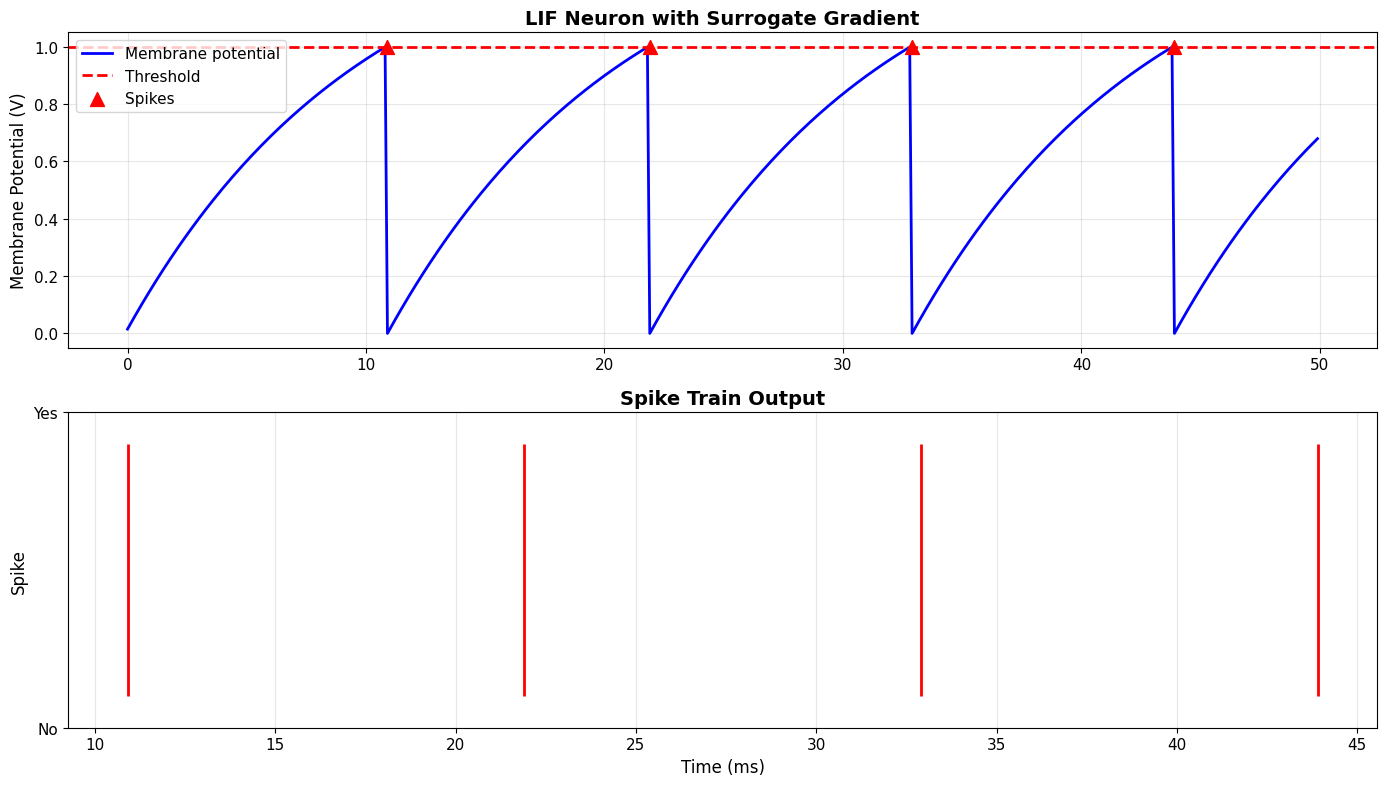


Simulation results:
• Total spikes: 4
• Firing rate: 80.0 Hz

✅ Spikes are discrete (0 or 1) in forward pass
✅ But gradients flow through via surrogate function!


In [10]:
# Simple LIF neuron with surrogate gradient
print("=== PRACTICAL EXAMPLE: LIF Neuron ===")

# LIF neuron parameters
tau = 10.0  # membrane time constant (ms)
v_th = 1.0  # threshold voltage
dt = 0.1    # time step (ms)

# Choose surrogate gradient
spike_grad = surrogate.Sigmoid(alpha=4.0)

def lif_step(v, i_input):
    """Single step of LIF neuron dynamics."""
    # Update membrane potential
    dv = (-v + i_input) / tau * dt
    v = v + dv
    
    # Generate spike with surrogate gradient
    spike = spike_grad(v - v_th)
    
    # Reset after spike
    v = v * (1.0 - spike)
    
    return v, spike

# Simulate neuron
n_steps = 500
i_input = jnp.ones(n_steps) * 1.5  # Constant input current

v_trace = []
spike_trace = []
v = jnp.array(0.0)

for i in range(n_steps):
    v, spike = lif_step(v, i_input[i])
    v_trace.append(float(v))
    spike_trace.append(float(spike))

v_trace = jnp.array(v_trace)
spike_trace = jnp.array(spike_trace)
time = jnp.arange(n_steps) * dt

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Membrane potential
ax1.plot(time, v_trace, 'b-', linewidth=2, label='Membrane potential')
ax1.axhline(v_th, color='red', linestyle='--', linewidth=2, label='Threshold')
spike_times = time[spike_trace > 0.5]
ax1.scatter(spike_times, jnp.ones_like(spike_times) * v_th, 
           color='red', s=100, zorder=5, label='Spikes', marker='^')
ax1.set_ylabel('Membrane Potential (V)', fontsize=12)
ax1.set_title('LIF Neuron with Surrogate Gradient', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Spikes
ax2.eventplot(spike_times, lineoffsets=0.5, linelengths=0.8, linewidths=2, color='red')
ax2.set_xlabel('Time (ms)', fontsize=12)
ax2.set_ylabel('Spike', fontsize=12)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No', 'Yes'])
ax2.set_title('Spike Train Output', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSimulation results:")
print(f"• Total spikes: {jnp.sum(spike_trace > 0.5):.0f}")
print(f"• Firing rate: {jnp.sum(spike_trace > 0.5) / (n_steps * dt) * 1000:.1f} Hz")
print(f"\n✅ Spikes are discrete (0 or 1) in forward pass")
print(f"✅ But gradients flow through via surrogate function!")

=== GRADIENT FLOW DEMONSTRATION ===


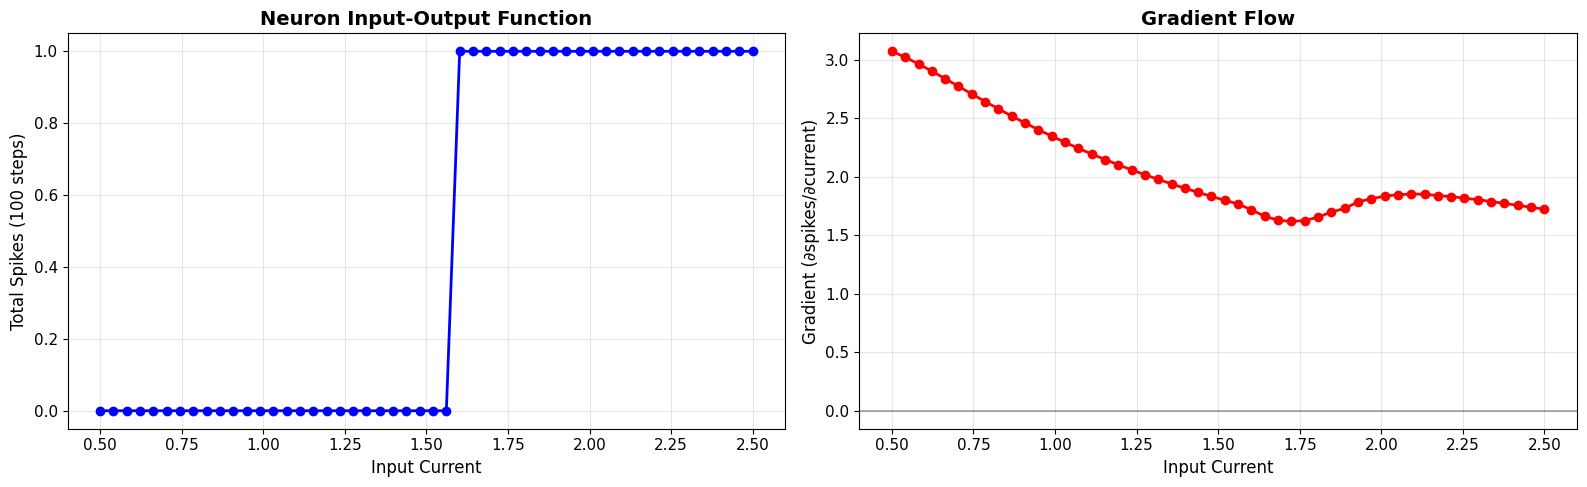


✅ Gradient successfully flows through spiking neuron!
✅ This enables learning in SNNs via backpropagation

Gradient statistics:
• Mean gradient: 2.0763
• Max gradient: 3.0740
• Min gradient: 1.6188


In [11]:
# Demonstrate gradient flow through neuron
print("=== GRADIENT FLOW DEMONSTRATION ===")

def neuron_output(i_input_value):
    """Compute total spikes for given input."""
    v = jnp.array(0.0)
    total_spikes = 0.0
    
    for _ in range(100):
        dv = (-v + i_input_value) / tau * dt
        v = v + dv
        spike = spike_grad(v - v_th)
        total_spikes = total_spikes + spike
        v = v * (1.0 - spike)
    
    return total_spikes

# Compute gradient of output w.r.t. input current
test_currents = jnp.linspace(0.5, 2.5, 50)
outputs = jax.vmap(neuron_output)(test_currents)
gradients = jax.vmap(jax.grad(neuron_output))(test_currents)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Input-output relationship
ax1.plot(test_currents, outputs, 'bo-', linewidth=2, markersize=6)
ax1.set_xlabel('Input Current', fontsize=12)
ax1.set_ylabel('Total Spikes (100 steps)', fontsize=12)
ax1.set_title('Neuron Input-Output Function', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Gradient of output w.r.t. input
ax2.plot(test_currents, gradients, 'ro-', linewidth=2, markersize=6)
ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Input Current', fontsize=12)
ax2.set_ylabel('Gradient (∂spikes/∂current)', fontsize=12)
ax2.set_title('Gradient Flow', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Gradient successfully flows through spiking neuron!")
print("✅ This enables learning in SNNs via backpropagation")
print(f"\nGradient statistics:")
print(f"• Mean gradient: {jnp.mean(gradients):.4f}")
print(f"• Max gradient: {jnp.max(gradients):.4f}")
print(f"• Min gradient: {jnp.min(gradients):.4f}")

## 7. Choosing the Right Surrogate

Different surrogates work better for different tasks. Here's a quick guide:

### Recommended Surrogates

| Surrogate | When to Use | Pros | Cons |
|-----------|-------------|------|------|
| **Sigmoid** | General purpose, default choice | Smooth, well-studied | Unbounded support |
| **Arctan** | Similar to Sigmoid | Smoother than sigmoid | Slower computation |
| **GaussianGrad** | Need precise gradient control | Symmetric, peaked | Requires sigma tuning |
| **PiecewiseQuadratic** | Memory efficiency important | Finite support, fast | Less smooth |
| **ReluGrad** | Deep SNNs | Finite support, stable | May need tuning |
| **SuperSpike (GaussianGrad)** | Research baseline | Well-studied | Standard choice |

### General Guidelines

1. **Start with Sigmoid** (α=4.0): Good default for most tasks
2. **Use GaussianGrad** for precise control: Popular in research
3. **Try PiecewiseQuadratic** for efficiency: Finite support saves memory
4. **Experiment with α**: Tune steepness for your specific task

### Performance Comparison

=== SURROGATE COMPARISON ON LIF NEURON ===


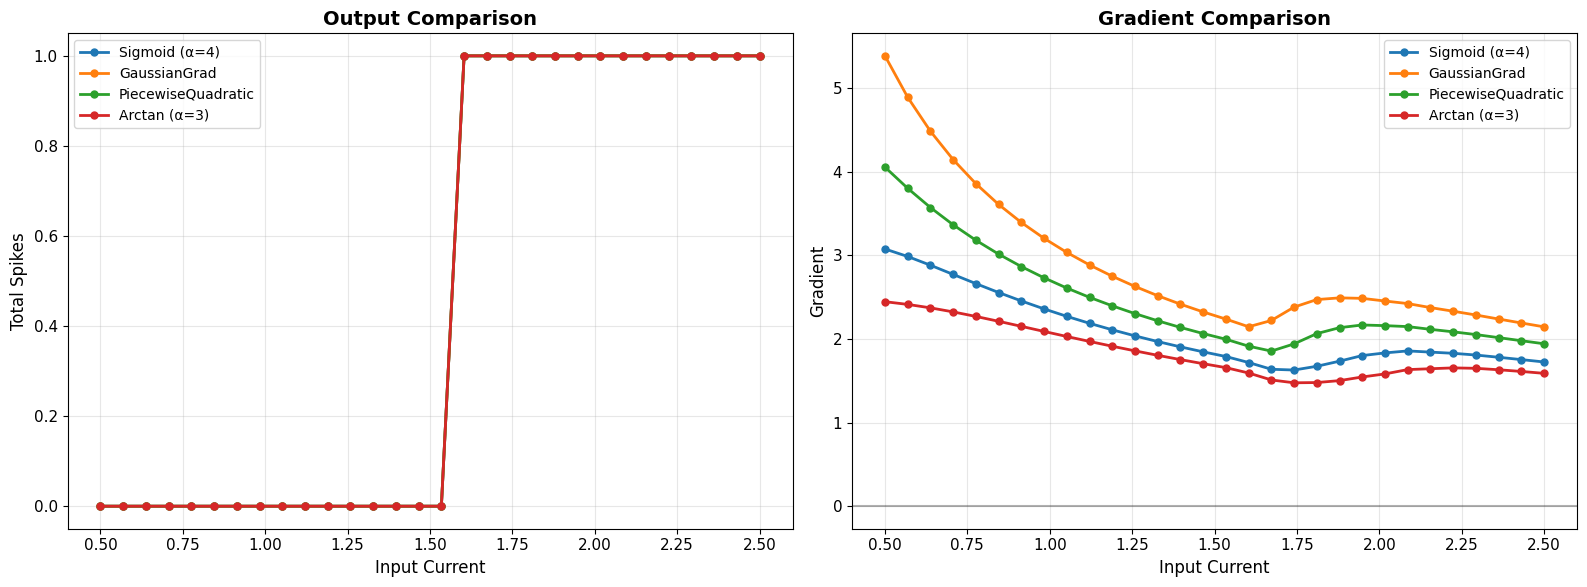


Observations:
• All surrogates produce same forward behavior (spikes)
• Different gradient magnitudes and shapes
• Choice affects learning dynamics, not output


In [12]:
# Compare different surrogates on the same task
print("=== SURROGATE COMPARISON ON LIF NEURON ===")

surrogates_to_test = {
    'Sigmoid (α=4)': surrogate.Sigmoid(alpha=4.0),
    'GaussianGrad': surrogate.GaussianGrad(sigma=0.5, alpha=1.0),
    'PiecewiseQuadratic': surrogate.PiecewiseQuadratic(alpha=1.0),
    'Arctan (α=3)': surrogate.Arctan(alpha=3.0),
}

test_currents = jnp.linspace(0.5, 2.5, 30)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for name, sg in surrogates_to_test.items():
    def neuron_with_surrogate(i_input_value):
        v = jnp.array(0.0)
        total_spikes = 0.0
        for _ in range(100):
            v = v + (-v + i_input_value) / tau * dt
            spike = sg(v - v_th)
            total_spikes = total_spikes + spike
            v = v * (1.0 - spike)
        return total_spikes
    
    outputs = jax.vmap(neuron_with_surrogate)(test_currents)
    gradients = jax.vmap(jax.grad(neuron_with_surrogate))(test_currents)
    
    axes[0].plot(test_currents, outputs, 'o-', linewidth=2, markersize=5, label=name)
    axes[1].plot(test_currents, gradients, 'o-', linewidth=2, markersize=5, label=name)

axes[0].set_xlabel('Input Current', fontsize=12)
axes[0].set_ylabel('Total Spikes', fontsize=12)
axes[0].set_title('Output Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Input Current', fontsize=12)
axes[1].set_ylabel('Gradient', fontsize=12)
axes[1].set_title('Gradient Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("• All surrogates produce same forward behavior (spikes)")
print("• Different gradient magnitudes and shapes")
print("• Choice affects learning dynamics, not output")